In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d bhavikjikadara/fake-news-detection

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 78% 32.0M/41.0M [00:00<00:00, 89.1MB/s]
100% 41.0M/41.0M [00:00<00:00, 63.3MB/s]


In [3]:
import zipfile
zip_path = '/content/fake-news-detection.zip'
extract_to = '/content/fake-news-detection'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [4]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow import keras

In [5]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
fake_data = pd.read_csv('/content/fake-news-detection/fake.csv')
true_data = pd.read_csv('/content/fake-news-detection/true.csv')

In [8]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [10]:
# Combine datasets and add labels
fake_data['target'] = 0
true_data['target'] = 1
data = pd.concat([fake_data, true_data]).reset_index(drop=True)

In [11]:
data.isnull().sum()

,0
title,0
text,0
subject,0
date,0
target,0


Visualization

target
0    23481
1    21417
Name: count, dtype: int64


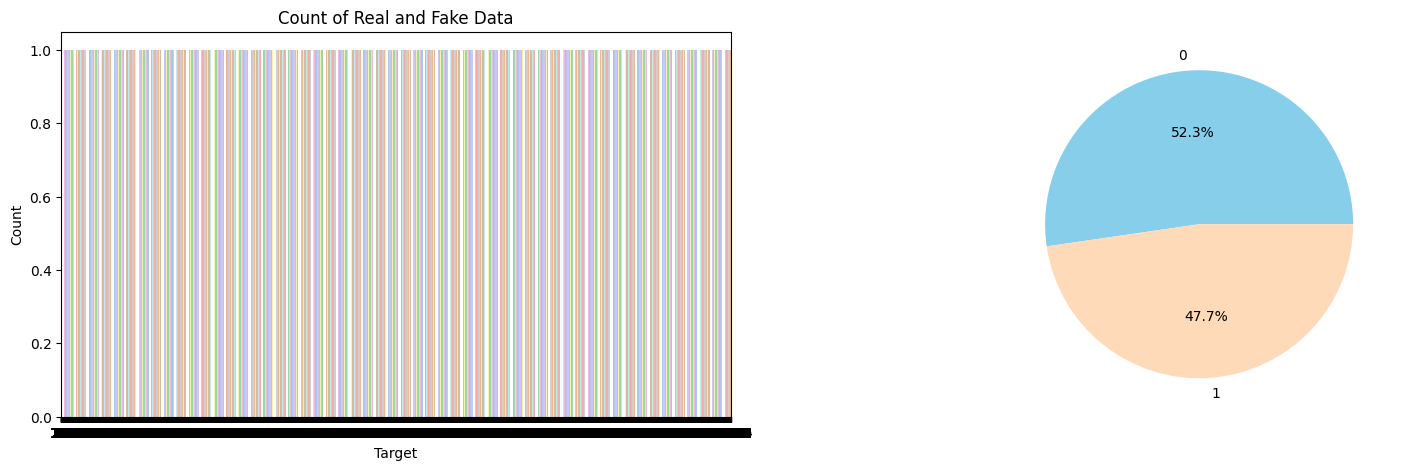

In [12]:
# Visualize the distribution of real and fake news
print(data["target"].value_counts())
fig, ax = plt.subplots(1, 2, figsize=(19, 5))
sns.countplot(data.target, ax=ax[0], palette="pastel").set(title="Count of Real and Fake Data", xlabel="Target", ylabel="Count")
ax[1].pie(data["target"].value_counts().values, labels=data.target.value_counts().index, autopct='%1.1f%%', colors=['SkyBlue', 'PeachPuff'])
fig.show()

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


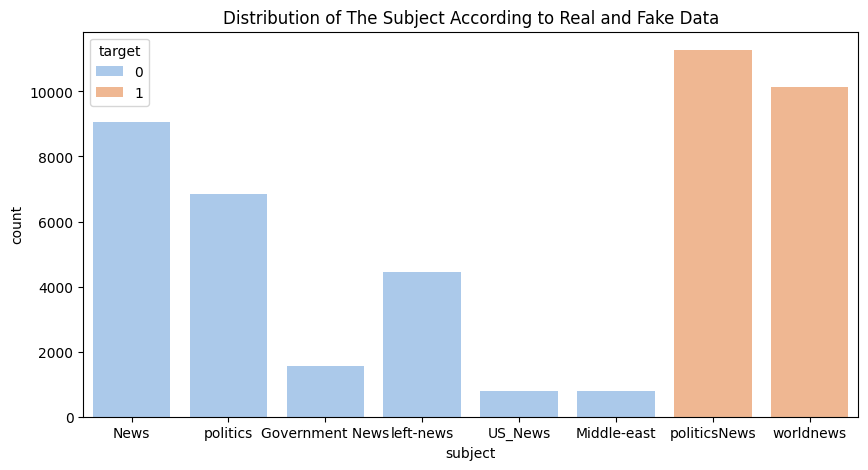

In [13]:
# Distribution of subjects
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))
sns.countplot(x="subject", hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")
plt.show()

Data Cleaning

In [14]:
# Data Cleaning
data['text'] = data.get('subject', '') + " " + data.get('title', '') + " " + data['text']
data.drop(columns=['title', 'subject', 'date'], errors='ignore', inplace=True)

In [15]:
first_text = data.text[10]
first_text

"News  Papa John’s Founder Retires, Figures Out Racism Is Bad For Business A centerpiece of Donald Trump s campaign, and now his presidency, has been his white supremacist ways. That is why so many of the public feuds he gets into involve people of color. One of his favorite targets, is, of course, the players in the National Football League who dare to exercise their First Amendment rights by kneeling during the national anthem in protest of racist police brutality. Well, there is one person who has figured out that racism is bad for business, even if it did get the orange overlord elected: The founder of the pizza chain Papa John s.This is a man who has never been on the right side of history on any number of issues, and plus his pizza sucks. But, when he decided to complain about the players protesting, his sales really dropped. Turns out racism doesn t pay, and we all know that corporations are all about the bottom line. Therefore, Papa John Schnatter will no longer be CEO of the h

In [16]:
soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

"News  Papa John’s Founder Retires, Figures Out Racism Is Bad For Business A centerpiece of Donald Trump s campaign, and now his presidency, has been his white supremacist ways. That is why so many of the public feuds he gets into involve people of color. One of his favorite targets, is, of course, the players in the National Football League who dare to exercise their First Amendment rights by kneeling during the national anthem in protest of racist police brutality. Well, there is one person who has figured out that racism is bad for business, even if it did get the orange overlord elected: The founder of the pizza chain Papa John s.This is a man who has never been on the right side of history on any number of issues, and plus his pizza sucks. But, when he decided to complain about the players protesting, his sales really dropped. Turns out racism doesn t pay, and we all know that corporations are all about the bottom line. Therefore, Papa John Schnatter will no longer be CEO of the h

Removal of Punctuation Marks and Special Characters

In [17]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'news  papa john s founder retires  figures out racism is bad for business a centerpiece of donald trump s campaign  and now his presidency  has been his white supremacist ways  that is why so many of the public feuds he gets into involve people of color  one of his favorite targets  is  of course  the players in the national football league who dare to exercise their first amendment rights by kneeling during the national anthem in protest of racist police brutality  well  there is one person who has figured out that racism is bad for business  even if it did get the orange overlord elected  the founder of the pizza chain papa john s this is a man who has never been on the right side of history on any number of issues  and plus his pizza sucks  but  when he decided to complain about the players protesting  his sales really dropped  turns out racism doesn t pay  and we all know that corporations are all about the bottom line  therefore  papa john schnatter will no longer be ceo of the h

Removal of Stopwords

In [18]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords

nltk.download("stopwords")

# Initialize the tokenizer
tokenizer = TreebankWordTokenizer()

first_text_tokens = tokenizer.tokenize(first_text)
print(first_text_tokens)

# Filter out stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in first_text_tokens if word.lower() not in stop_words]
print(filtered_tokens)

['news', 'papa', 'john', 's', 'founder', 'retires', 'figures', 'out', 'racism', 'is', 'bad', 'for', 'business', 'a', 'centerpiece', 'of', 'donald', 'trump', 's', 'campaign', 'and', 'now', 'his', 'presidency', 'has', 'been', 'his', 'white', 'supremacist', 'ways', 'that', 'is', 'why', 'so', 'many', 'of', 'the', 'public', 'feuds', 'he', 'gets', 'into', 'involve', 'people', 'of', 'color', 'one', 'of', 'his', 'favorite', 'targets', 'is', 'of', 'course', 'the', 'players', 'in', 'the', 'national', 'football', 'league', 'who', 'dare', 'to', 'exercise', 'their', 'first', 'amendment', 'rights', 'by', 'kneeling', 'during', 'the', 'national', 'anthem', 'in', 'protest', 'of', 'racist', 'police', 'brutality', 'well', 'there', 'is', 'one', 'person', 'who', 'has', 'figured', 'out', 'that', 'racism', 'is', 'bad', 'for', 'business', 'even', 'if', 'it', 'did', 'get', 'the', 'orange', 'overlord', 'elected', 'the', 'founder', 'of', 'the', 'pizza', 'chain', 'papa', 'john', 's', 'this', 'is', 'a', 'man', 'wh

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatization

In [19]:
lemmatizer = nltk.WordNetLemmatizer()
first_text = [ lemmatizer.lemmatize(word) for word in first_text]

first_text = " ".join(first_text)
first_text

'n e w s     p a p a   j o h n   s   f o u n d e r   r e t i r e s     f i g u r e s   o u t   r a c i s m   i s   b a d   f o r   b u s i n e s s   a   c e n t e r p i e c e   o f   d o n a l d   t r u m p   s   c a m p a i g n     a n d   n o w   h i s   p r e s i d e n c y     h a s   b e e n   h i s   w h i t e   s u p r e m a c i s t   w a y s     t h a t   i s   w h y   s o   m a n y   o f   t h e   p u b l i c   f e u d s   h e   g e t s   i n t o   i n v o l v e   p e o p l e   o f   c o l o r     o n e   o f   h i s   f a v o r i t e   t a r g e t s     i s     o f   c o u r s e     t h e   p l a y e r s   i n   t h e   n a t i o n a l   f o o t b a l l   l e a g u e   w h o   d a r e   t o   e x e r c i s e   t h e i r   f i r s t   a m e n d m e n t   r i g h t s   b y   k n e e l i n g   d u r i n g   t h e   n a t i o n a l   a n t h e m   i n   p r o t e s t   o f   r a c i s t   p o l i c e   b r u t a l i t y     w e l l     t h e r e   i s   o n e   p e r s o n   w h o

In [20]:
# Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub(r"[^a-zA-Z]", " ", text)

# Removal of stopwords and Lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    tokens = tokenizer.tokenize(text)

    for word in tokens:
        if word not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word)
            final_text.append(lemmatized_word)
    return " ".join(final_text)

# Total Cleaning Function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

# Apply the cleaning function to the 'text' column
data['text'] = data['text'].apply(cleaning)

In [21]:
data.head()

,text,target
0,news donald trump sends embarrassing new year ...,0
1,news drunk bragging trump staffer started russ...,0
2,news sheriff david clarke becomes internet jok...,0
3,news trump obsessed even obama name coded webs...,0
4,news pope francis called donald trump christma...,0


WordCloud for Real News

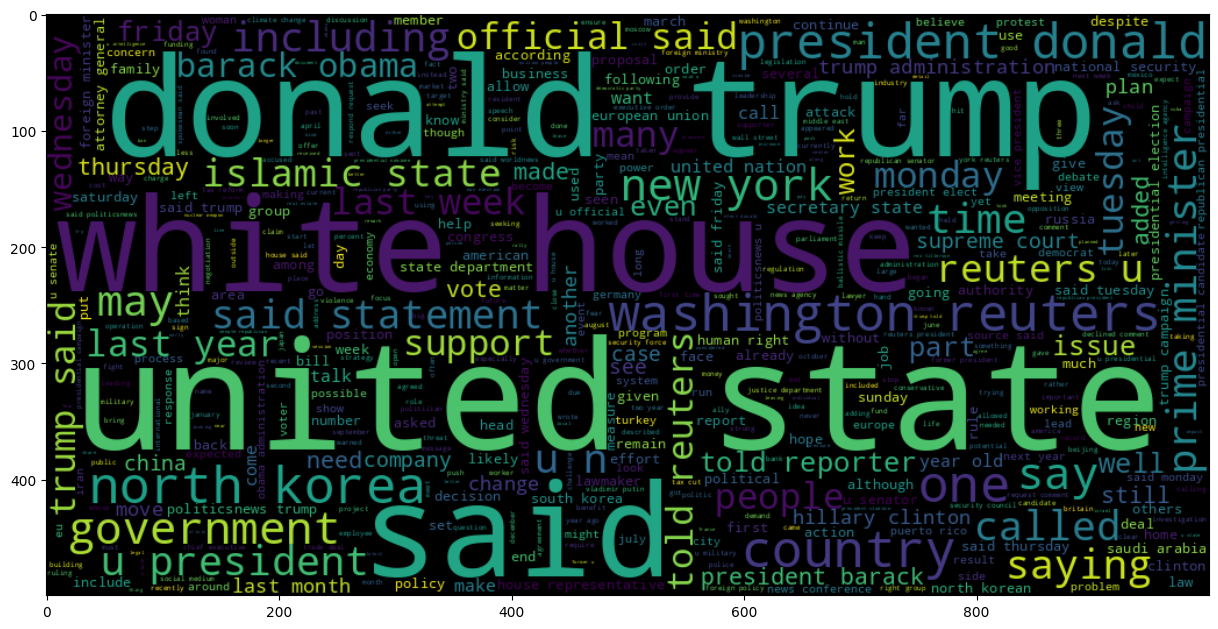

In [22]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

WordCloud for Fake News

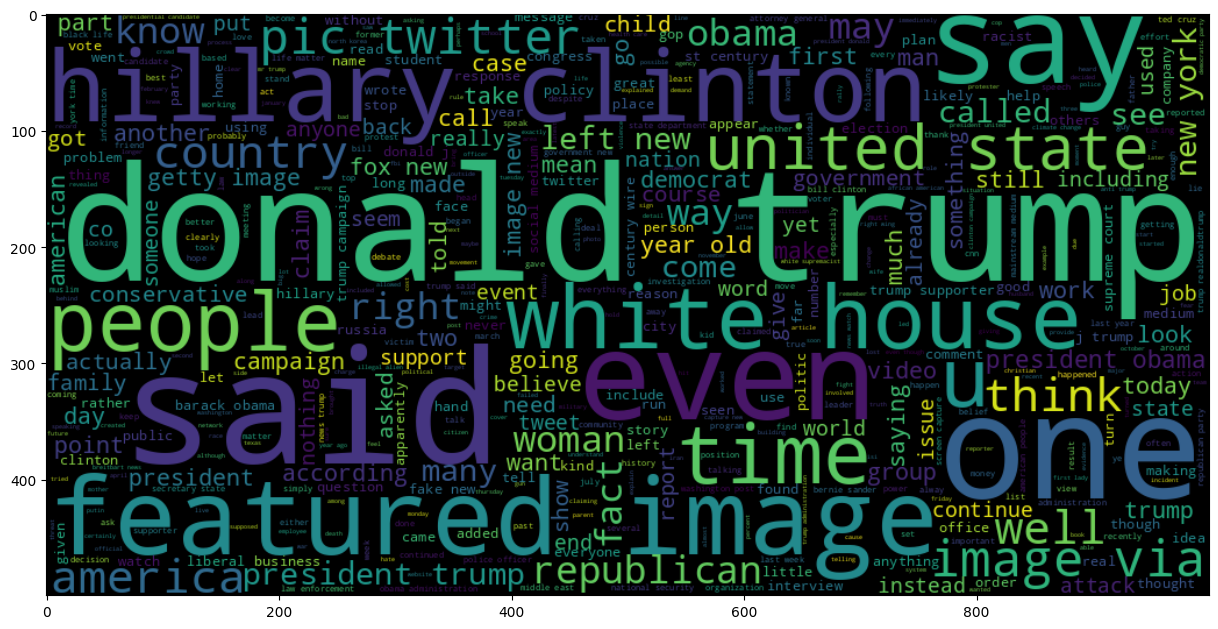

In [23]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

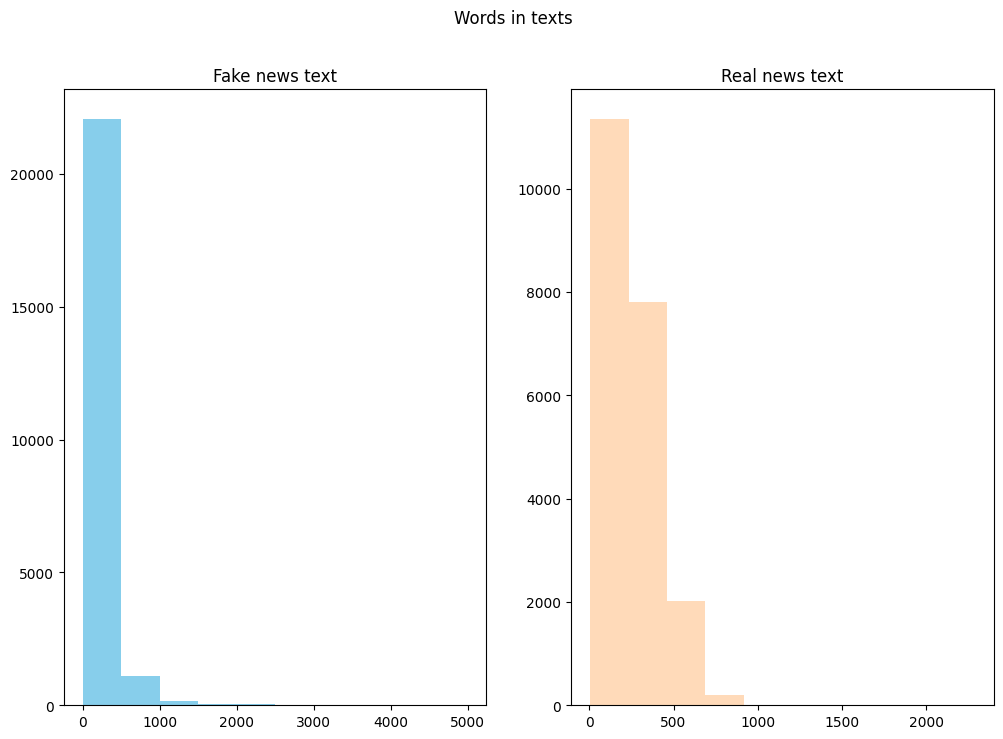

In [24]:
# Number of words in each set
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

N-gram Analysis

In [25]:
texts = ' '.join(data['text'])

In [26]:
string = texts.split(" ")

In [27]:
def draw_n_gram(text_input, n):
    """
    Draws a bar plot of the top n-grams in the input text.

    Parameters:
    - text_input: Can be a string (raw text) or a list of tokens.
    - n: The size of the n-gram (1 for unigram, 2 for bigram, 3 for trigram).
    """

    # If the input is a string, split into tokens
    if isinstance(text_input, str):
        tokens = text_input.split()
    elif isinstance(text_input, list):
        tokens = text_input
    else:
        raise ValueError("Input should be either a string or a list of tokens.")

    # Generate n-grams
    n_grams = list(nltk.ngrams(tokens, n))

    # Create a DataFrame from n-grams and count frequencies
    n_gram_series = pd.Series(n_grams).value_counts()[:15]
    n_gram_df = n_gram_series.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})

    # Convert tuple to string for display purposes
    n_gram_df['word'] = n_gram_df['word'].apply(lambda x: ' '.join(x))

    plt.figure(figsize=(16, 9))
    sns.barplot(x='count', y='word', data=n_gram_df, palette='crest')  # Using a colorful palette
    plt.title(f'Top {n}-grams', fontsize=18)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel(f'{n}-gram', fontsize=14)
    plt.show()

Unigram Analysis

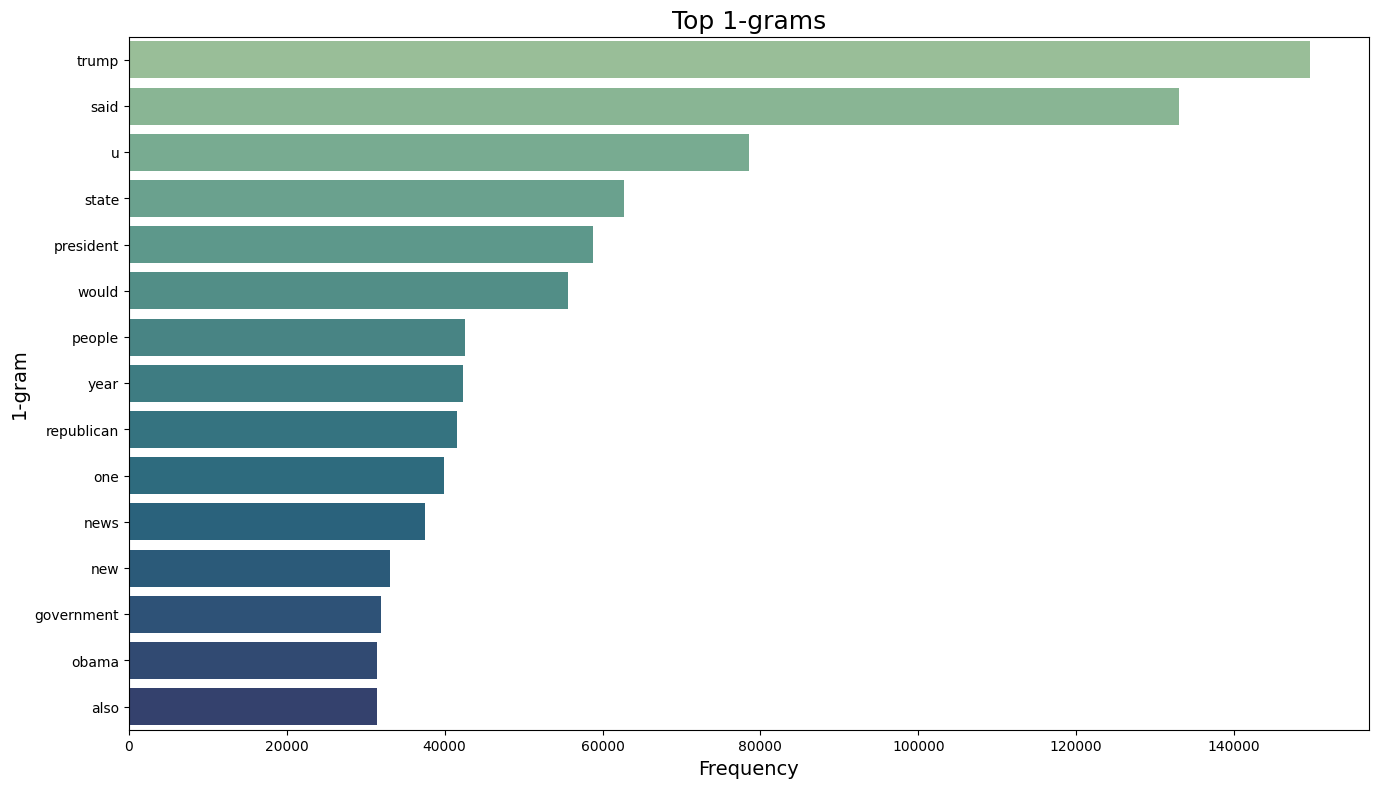

In [28]:
draw_n_gram(string,1)

Bigram Analysis

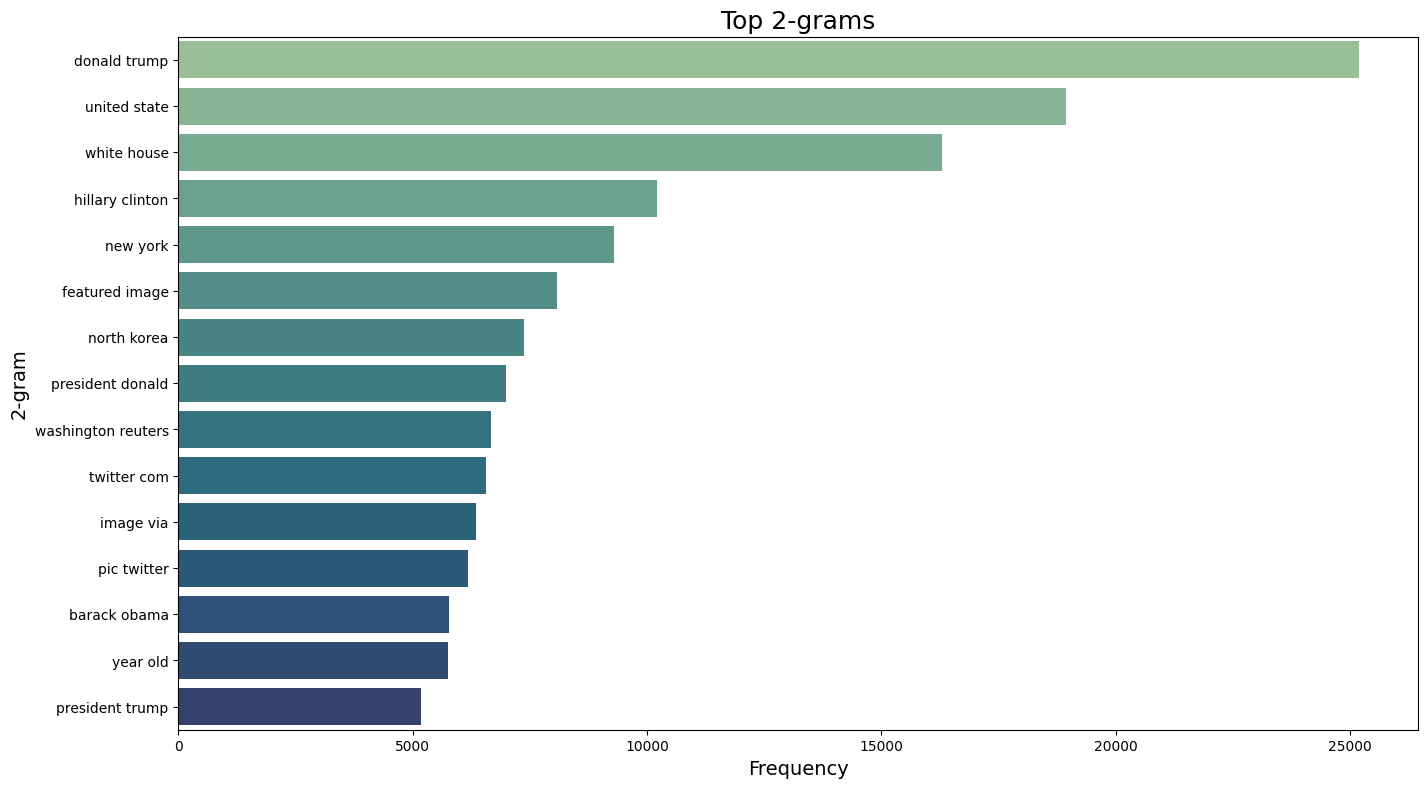

In [29]:
draw_n_gram(string,2)

Trigram Analysis

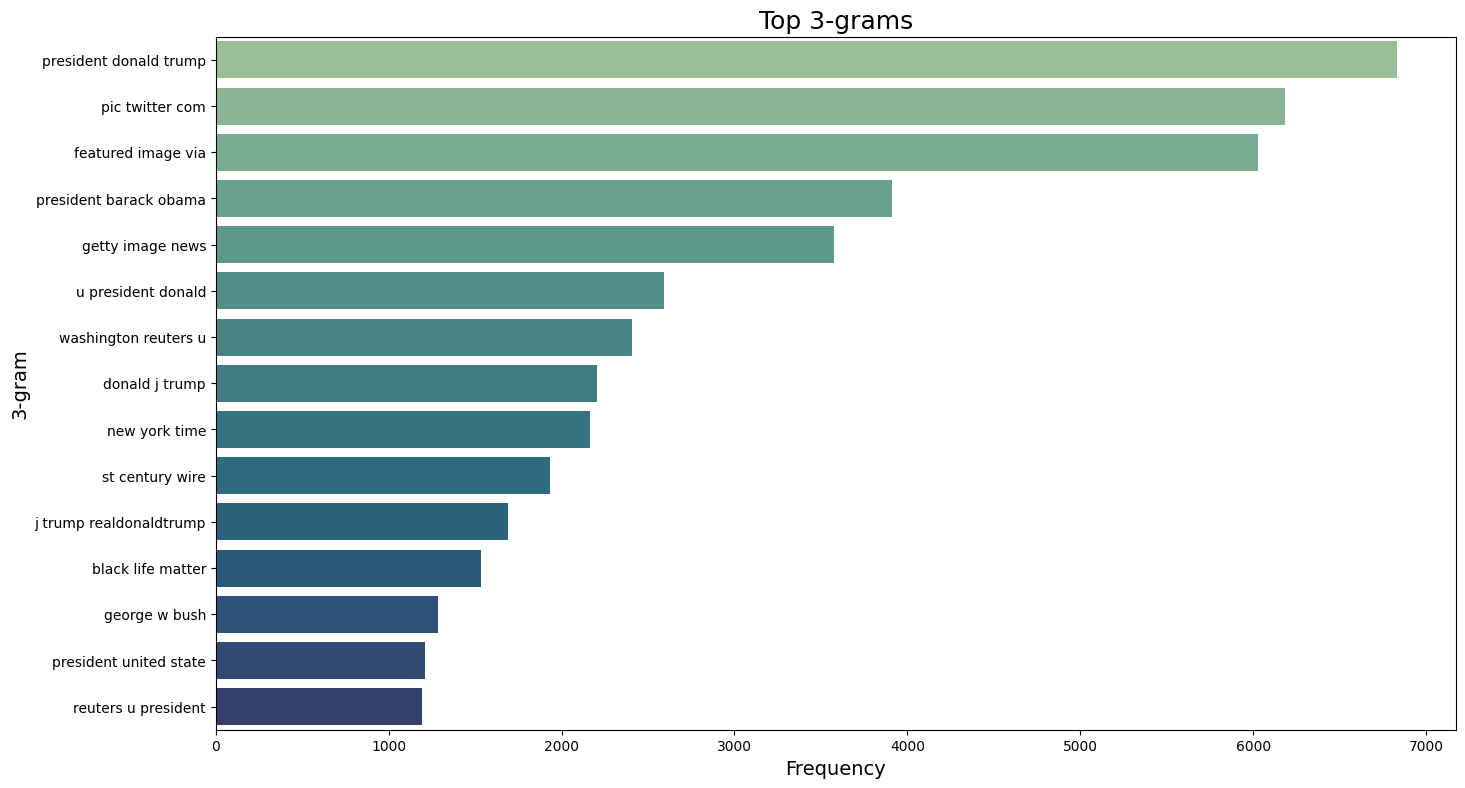

In [30]:
draw_n_gram(string,3)

**Tokenizing**

Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

Lets keep all news to 500, add padding to news with less than 500 words and truncating long ones

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
max_features = 10000
maxlen = 500

In [33]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['text'])
X = tokenizer.texts_to_sequences(data['text'])
X = sequence.pad_sequences(X, maxlen=maxlen)

In [34]:
y = data['target']

In [35]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

***Training LSTM Model***

In [36]:
batch_size = 256
embed_size = 100

In [37]:
# LSTM Model
model = Sequential([
    Embedding(input_dim=max_features, output_dim=100, input_length=maxlen, trainable=True),
    LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [38]:
# Compile and build the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 500, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168,769 (4.46 MB)

 Trainable params: 1,168,769 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Model Training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256, shuffle=True)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 465s 4s/step - accuracy: 0.8516 - loss: 0.3444 - val_accuracy: 0.9836 - val_loss: 0.0571
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.9883 - loss: 0.0383 - val_accuracy: 0.9902 - val_loss: 0.0386
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.9932 - loss: 0.0244 - val_accuracy: 0.9915 - val_loss: 0.0358
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.9927 - loss: 0.0245 - val_accuracy: 0.9875 - val_loss: 0.0461
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.9946 - loss: 0.0197 - val_accuracy: 0.9892 - val_loss: 0.0429


In [40]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

983/983 ━━━━━━━━━━━━━━━━━━━━ 531s 539ms/step - accuracy: 0.9978 - loss: 0.0082
Accuracy of the model on Training Data is -  99.78363513946533 %
421/421 ━━━━━━━━━━━━━━━━━━━━ 227s 538ms/step - accuracy: 0.9873 - loss: 0.0502
Accuracy of the model on Testing Data is -  98.92353415489197 %


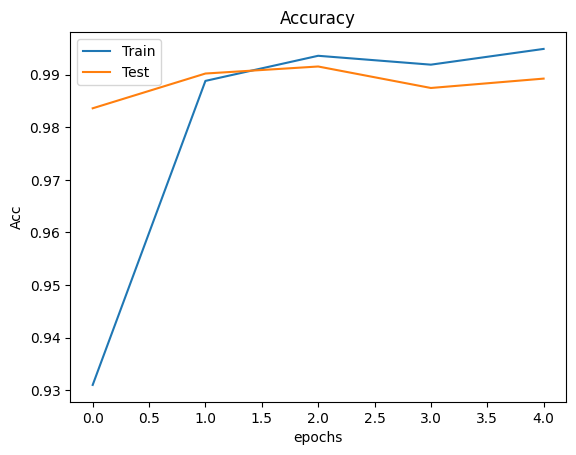

In [41]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

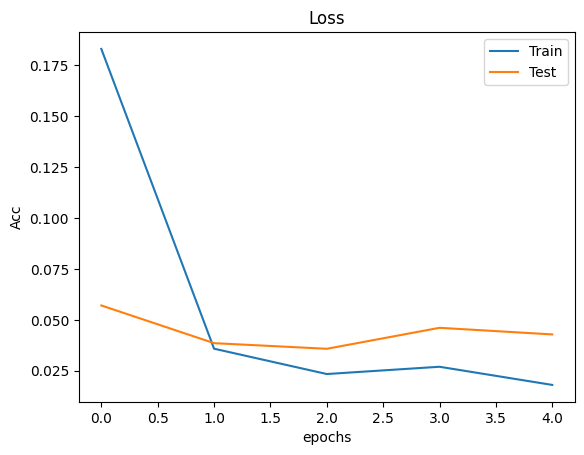

In [42]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import classification_report
pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob, axis=-1)
# If y_test is one-hot encoded, convert it
if y_test.ndim > 1:
    y_test_labels = np.argmax(y_test, axis=-1)
else:
    y_test_labels = y_test
print(classification_report(y_test, pred, target_names=['Fake', 'Real']))

421/421 ━━━━━━━━━━━━━━━━━━━━ 227s 539ms/step
              precision    recall  f1-score   support

        Fake       0.53      1.00      0.69      7091
        Real       0.00      0.00      0.00      6379

    accuracy                           0.53     13470
   macro avg       0.26      0.50      0.34     13470
weighted avg       0.28      0.53      0.36     13470

